# 老鼠楽文章重新组织

2020年11月26日 重新设计，2020年12月3日 重新分析数据。

文章修改思路：

- 之前的文章太长，没有重点，所有实验结果都拿去进行了展示和讨论，应该大规模精简，突出最 significant、最 solid 的观点。
- 不同地点之间的对比，增加了变量，但没有得出亮眼、可靠但结论，在正文删除。
- 修改显著性水平至（0.05），重新应用重复测量方差分析，关注混合效应（沙埋处理 * 时间）双因素影响下的显著性变化。
- 根据混合重复测量方差分析的结果，对显著性的结果进行深入分析，包括沙埋后多久产生显著差异。这些详细的重要结果在之前的版本里无法展示。
- 美观图片，该用标准误进 (Standard Error) 行作图，取代错误的标准差 (Standard Diverse)，关于标准差和标准误的区别见[这篇博客](https://www.zhihu.com/question/22864111)。简单来说标准差是对取样误差的度量，但是标准误是对数据均值变化范围的度量，所以在对 “均值” 作图时应该展示的是标准误而非标准差。

In [1]:
# 导入清洗数据所需的包
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # 高清作图

# 绘图风格
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'

# 自定义配色
nature_colors = {
    'NS': "#c83c1c",
    'Nature': "#29303c",
    'NCC': "#0889a6",
    'NC': "#f1801f",
    'NG': "#006c43",
    'NHB': "#1951A0",
    'NEE': "#C7D530"
}

# 根据自定义配色生成调色板
nature_palette = sns.color_palette(nature_colors.values())
sns.set_palette(nature_palette)

## 数据清洗

此次实验实施于2016年7月11日至31日。7月11日首先测量并埋下植株，之后分别测了五次，至31号整体挖出植株并打包带走。

植株在第一次沙埋后就遭遇了台风有所损毁，之后也有少数植株死亡，所以原始数据需要处理缺失值。原始数据来自于小五提供的电子录入版本。

植株干重测定的原始数据在被黄一鑫弄坏的硬盘里，所以没办法找寻了，只能通过计算过后的表格数据进行重新整理作图。

### 实验示意图：

<img src="../figs/diagram.jpg" alt="Drawing" style="width: 800px;"/>

### 清洗原始数据的每个小表并合成总表

In [2]:
def fill_col_by_last_value(col):
    """
    使用一列最后出现的值填充这一列
    col: 需要填充的列
    """
    output_list = []
    mask_col = col.isna()
    last_value = col.iloc[0]
    for i in range(len(col)):
        if mask_col.iloc[i]:
            output_list.append(last_value)
        else:
            value = col.iloc[i]
            output_list.append(value)
            last_value = value
    return output_list


def generate_index(length, section=6):
    """
    根据一定的重复（section）为所有数据（length）重新生成编号
    length: 需要为多少列数据重新生成编号？
    section: 每x个数据为一个重新编号的数据？
    """
    flag = 0
    new_index = []
    for i in range(length):
        if i % section == 0:
            flag += 1
        new_index.append(flag)
    return new_index 

In [3]:
def original_data_clean(data):
    """
    将原始数据进行清理
    data: 原始数据（xsls格式）的一个sheet
    """
    
    # 列名清洗
    data.columns = [name.strip() for name in data]
    
    # 将需要空值填充的列填充
    data = data.dropna(axis=0, how='all').dropna(axis=1, how='all')   # 去掉所有空行列
    fill_cols = ['沙埋覆盖情况', '编号']
    for col_name in fill_cols:
        if col_name in data:
            data[col_name] = fill_col_by_last_value(data[col_name])
            print("Fill by the last value in column: {}".format(col_name))
            
    # 合成计算不定根总长度
    column_names = data.columns.tolist()
    if '不定根长' in data:
        root_index = column_names.index('不定根长')
        data['不定根长'] = data.iloc[:, root_index:].sum(axis=1)
        drop_labels = column_names[root_index+1:]
        data.drop(axis=1, labels=drop_labels, inplace=True)
    else:
        data['不定根长'] = 0
    data['不定根长'].fillna(0)

    # 重新编号
    data['编号'] = generate_index(len(data))
    
    # 计算匍匐茎总长度
    data['茎长'] = data[['第一节长', '第二节长', '第三节长']].sum(axis=1)

    return data

In [4]:
# 遍历所有需要使用的原始数据

origin_data_path = "../data/沙埋数据.xlsx"  # 数据路径
sheets = ['迎风坡全埋', '迎风坡半埋', '迎风坡空白']  # 这次
missing_values = ['—']  # 代表缺失值的符号

merged_data = pd.DataFrame()  # 用来存数据的新表

for sheet in sheets:
    tmp_data = pd.read_excel(origin_data_path, sheet_name=sheet, na_values=missing_values)
    tmp_data = original_data_clean(tmp_data)
    if sheet == '迎风坡空白':
        tmp_data['沙埋覆盖情况'] = '无'
        tmp_data['沙埋厚度'] = '无'
    else:
        tmp_data['沙埋厚度'] = sheet.strip('迎风坡')
    merged_data = merged_data.append(tmp_data)
    
merged_data['编号'] = generate_index(len(merged_data))
print("\n整合后的数据：")
merged_data

Fill by the last value in column: 沙埋覆盖情况
Fill by the last value in column: 编号
Fill by the last value in column: 沙埋覆盖情况
Fill by the last value in column: 编号
Fill by the last value in column: 编号

整合后的数据：


,沙埋覆盖情况,编号,日期(7月）,备注,第一节长,第二节长,第三节长,株高,不定根数,不定根长,茎长,沙埋厚度
0,三分之一,1,11.0,NaN,13.0,10.0,13.0,19.0,0.0,0.0,36.0,全埋
1,三分之一,1,16.0,NaN,13.0,10.0,16.0,24.0,0.0,0.0,39.0,全埋
2,三分之一,1,20.0,NaN,14.0,11.0,19.0,26.0,0.0,0.0,44.0,全埋
3,三分之一,1,24.0,NaN,14.0,11.0,21.0,27.0,0.0,0.0,46.0,全埋
4,三分之一,1,28.0,NaN,14.0,12.0,21.0,27.0,0.0,0.0,47.0,全埋
...,...,...,...,...,...,...,...,...,...,...,...,...
29,无,35,16.0,NaN,19.0,14.0,27.0,37.0,0.0,0.0,60.0,无
30,无,35,20.0,NaN,20.0,14.0,27.0,40.0,0.0,0.0,61.0,无
31,无,35,24.0,NaN,22.0,14.0,28.0,40.0,0.0,0.0,64.0,无
32,无,35,28.0,NaN,23.0,15.0,28.0,41.0,0.0,0.0,66.0,无


### 对合成后对表转为英语

方便后续用编程处理

In [5]:
# 列名和对应的英文
col_names_eng = {
    '编号': 'num',
    '沙埋覆盖情况': 'bur_x',
    '沙埋厚度': 'bur_y',
    '日期(7月）': 'time',
    '第一节长': 'base',
    '第二节长': 'middle',
    '第三节长': 'top',
    '茎长': 'length',
    '株高': 'height',
    '不定根数': 'adventitious roots',
    '不定根长': 'total length of adventitious roots',
    '备注': 'note',
    'treatment': 'treatment'
}

# 处理方式
sand_burial_eng = {
    '全埋': 'Complete',
    '半埋': 'Half',
    '无': 'No',
    '三分之一': 'Light',
    '三分之二': 'Moderate',
    '三分之三': 'Intense'
}


# 清理整合的数据表
def clean_merged_data(data):
    data = data.rename(col_names_eng, axis=1)  # 列重命名
    data.replace(sand_burial_eng, inplace=True)  # 处理方式转英文
    data['treatment'] = data['bur_y'].str[0] + data['bur_x'].str[0]  # 根据x、y分别的处理方式，为总处理方式标记
    data.replace({'NN': 'CG'}, inplace=True)  # 空白对照组
    data = data[col_names_eng.values()]  # 列重新排列顺序
    return data


merged_data = clean_merged_data(merged_data)
merged_data

,num,bur_x,bur_y,time,base,middle,top,length,height,adventitious roots,total length of adventitious roots,note,treatment
0,1,Light,Complete,11.0,13.0,10.0,13.0,36.0,19.0,0.0,0.0,NaN,CL
1,1,Light,Complete,16.0,13.0,10.0,16.0,39.0,24.0,0.0,0.0,NaN,CL
2,1,Light,Complete,20.0,14.0,11.0,19.0,44.0,26.0,0.0,0.0,NaN,CL
3,1,Light,Complete,24.0,14.0,11.0,21.0,46.0,27.0,0.0,0.0,NaN,CL
4,1,Light,Complete,28.0,14.0,12.0,21.0,47.0,27.0,0.0,0.0,NaN,CL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,35,No,No,16.0,19.0,14.0,27.0,60.0,37.0,0.0,0.0,NaN,CG
30,35,No,No,20.0,20.0,14.0,27.0,61.0,40.0,0.0,0.0,NaN,CG
31,35,No,No,24.0,22.0,14.0,28.0,64.0,40.0,0.0,0.0,NaN,CG
32,35,No,No,28.0,23.0,15.0,28.0,66.0,41.0,0.0,0.0,NaN,CG


### 处理缺失值

处理缺失值的主要思路：

- 检查含有缺失值的植株数据，如果某变量缺失值超过2个，认为该植株的数据已经不可靠，在分析中排除
- 需要检查缺失值的变量：匍匐茎长度、植株高度、不定根数量、不定根长度
- 用*同样处理*、*不同编号*的植株在*同一天*的数据**均值**填充缺失值
- 判断逆生长：假设匍匐茎长度和植株高度不能逆向生长，如果出现逆向生长则认为改变量无变化（经试验该处理方法严重影响数据，因此未采用）
- 判断匍匐茎各段长度。根据逻辑有“$基部+中部+顶端=匍匐茎总长$”，如果某数据只缺失三段中的某一个值，则通过减法进行插补。如果缺失多个值，则用*同样处理*、*不同编号*的植株在*同一天*的数据**三段的平均占比**乘以匍匐茎总长进行计算和插补。
- 判断逻辑一致性：如果没有不定根数量，则不定根总长度一定为0。

To many missing values in 3
To many missing values in 13
To many missing values in 28


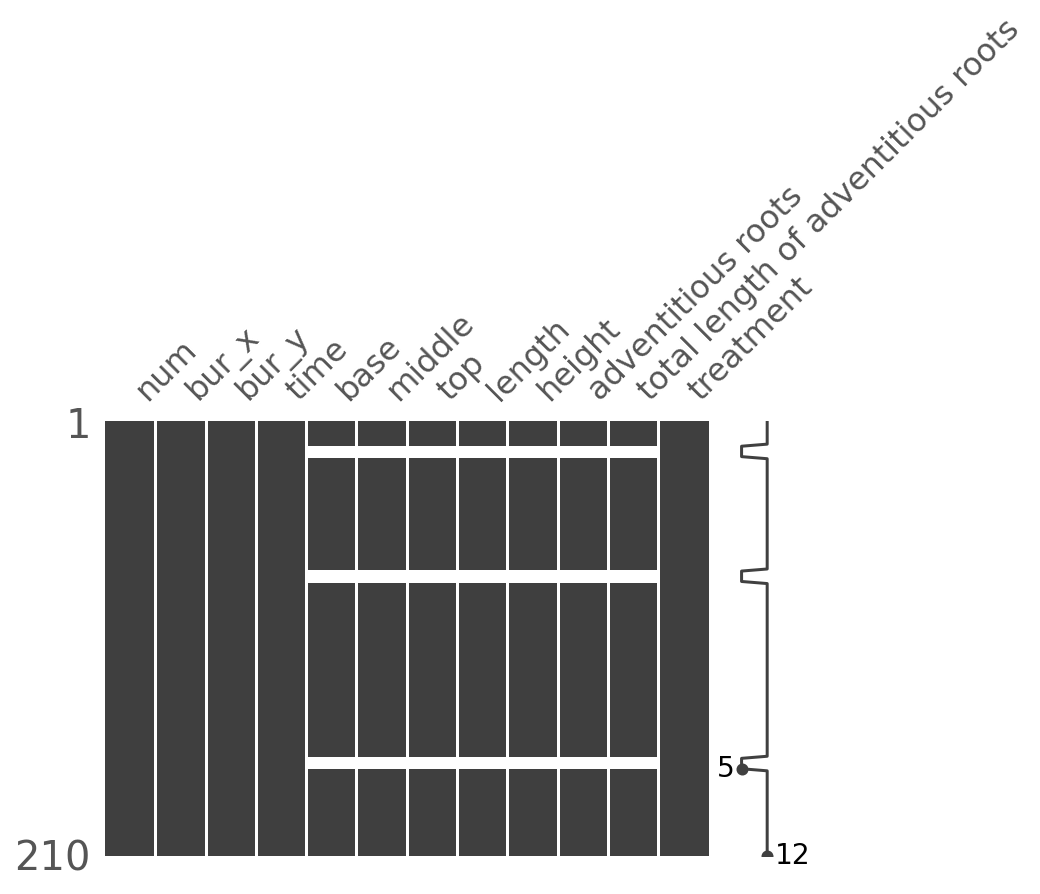

In [6]:
# 匍匐茎和株高不能逆生长
def sort_order_by_growth(col):
    """
    每一颗植株按照其生长规律，不能逆向生长
    col 是每一颗植株（时间不同）的某序列
    返回纠正生长（用上一次测量值代替逆向生长）的序列
    """
    output = []
    last_value = col.iloc[0]
    for value in col.values:
        if value < last_value:
            output.append(last_value)
        else:
            output.append(value)
            last_value = value
    return pd.Series(output, index=col.index)
            
    
# 处理缺失值
def clean_missing_data(data, num):
    check_missing_variables = ['base', 'middle', 'top', 'length', 'height', 'total length of adventitious roots', 'adventitious roots']  # 检查缺失值的变量
    mean_fill_variables = ['length', 'height', 'total length of adventitious roots', 'adventitious roots']  # 用均值填充的变量
    unreversable_variables = ['length', 'height']  # 不可逆生长的变量
    sections = ['base', 'middle', 'top']  # 三个部分
    output_data = data[data['num'] == num].copy()  # 这颗植株的数据
    
    # 每个植株，如果缺失值最多的一个变量，超过两天有缺失值，就不要了
    if output_data[check_missing_variables].isna().sum(axis=0).max() > 2:
        print("To many missing values in {}".format(num))
        output_data[check_missing_variables] = np.nan
        return output_data.drop('note', axis=1)
    
    # 丢掉严重有问题的数据
    drop_num = []
    if num in drop_num:
        output_data[check_missing_variables] = np.nan
        return output_data.drop('note', axis=1)
    
    # 用同样处理的、其它植株在此日的平均值进行填补
    for index, row in output_data.iterrows():
        
        if row[check_missing_variables].isna().sum() == 0:  # 需要检查的变量没有缺失值
            continue
        
        else: # 需要检查的变量有缺失值
            treatment = row['treatment']  # 植株的处理方式
            time = row['time']  # 此次测量的时间
            mask1 = data['treatment']==treatment  # 同样的处理方式
            mask2 = data['time']==time  # 同样的测定时间
            mask3 = data['num'] != num  # 其它的植株
            similar_data = data[mask1 & mask2 & mask3]  # 用上述三个条件获取相似的植株
            
            # 首先均值填补
            for variable in mean_fill_variables:
                if variable in unreversable_variables:  # 株高和茎长不可能是0
                    mean = similar_data[similar_data[variable] > 0][variable].mean()
                else:
                    mean = similar_data[variable].mean()
                output_data.loc[index, variable] = round(mean, 0)  # 代替该植株、该日的该变量
                
            # 均值插补处理后，如果各部分长度之间仅存在一个缺失值，就通过加减法获取
            if row[sections].isna().sum() == 1:
                missing_section = row[sections][row.isna()].index.tolist()
                difference = output_data.loc[index, 'length'] - row[sections][row.notna()].sum()
                if difference < 0:  # 如果这样计算行不通，说明这个植株的三分线绑的有问题，用其它的均值来插补
                    row[sections] = np.nan
                output_data.loc[index, missing_section] = difference
            
            # 如果各部分长度缺失值超过一个，则用长度比例数据获取：
            if row[sections].isna().sum() > 1:
                ratios = similar_data[sections].sum(axis=0) / similar_data['length'].sum()
                output_data.loc[index, sections] = output_data.loc[index, 'length'] * ratios
                
#     # 判断逆生长问题
#     for v in unreversable_variables:
#         output_data[v] = sort_order_by_growth(output_data[v])
        
    # 如果没有不定根总长度，那一定没有不定根
    no_roots_mask = output_data['total length of adventitious roots'] == 0
    output_data.loc[no_roots_mask, 'adventitious roots'] = 0
    
    return output_data.drop('note', axis=1)


# 处理全部的数据：
cleaned_data = pd.DataFrame()
for num in merged_data['num'].unique():
    output = clean_missing_data(merged_data, num)
    cleaned_data = cleaned_data.append(output)
    
# 快速根据编号确认数据
def check_original_data_by_num(num):
    df = merged_data[merged_data['num'] == num]
    return df

def check_cleaned_data_by_num(num):
    df2 = cleaned_data[cleaned_data['num'] == num]
    return df2


import missingno as msno
msno.matrix(cleaned_data, figsize=(6, 4));

可以看到，一共有三个植株因为缺失值过多而被抛弃不参与后续分析，其它单独的缺失值均通过上述逻辑成功插补。

### 确认数据质量

绘制按照时间变化的每个样本，看看大体上是否有不合理之处

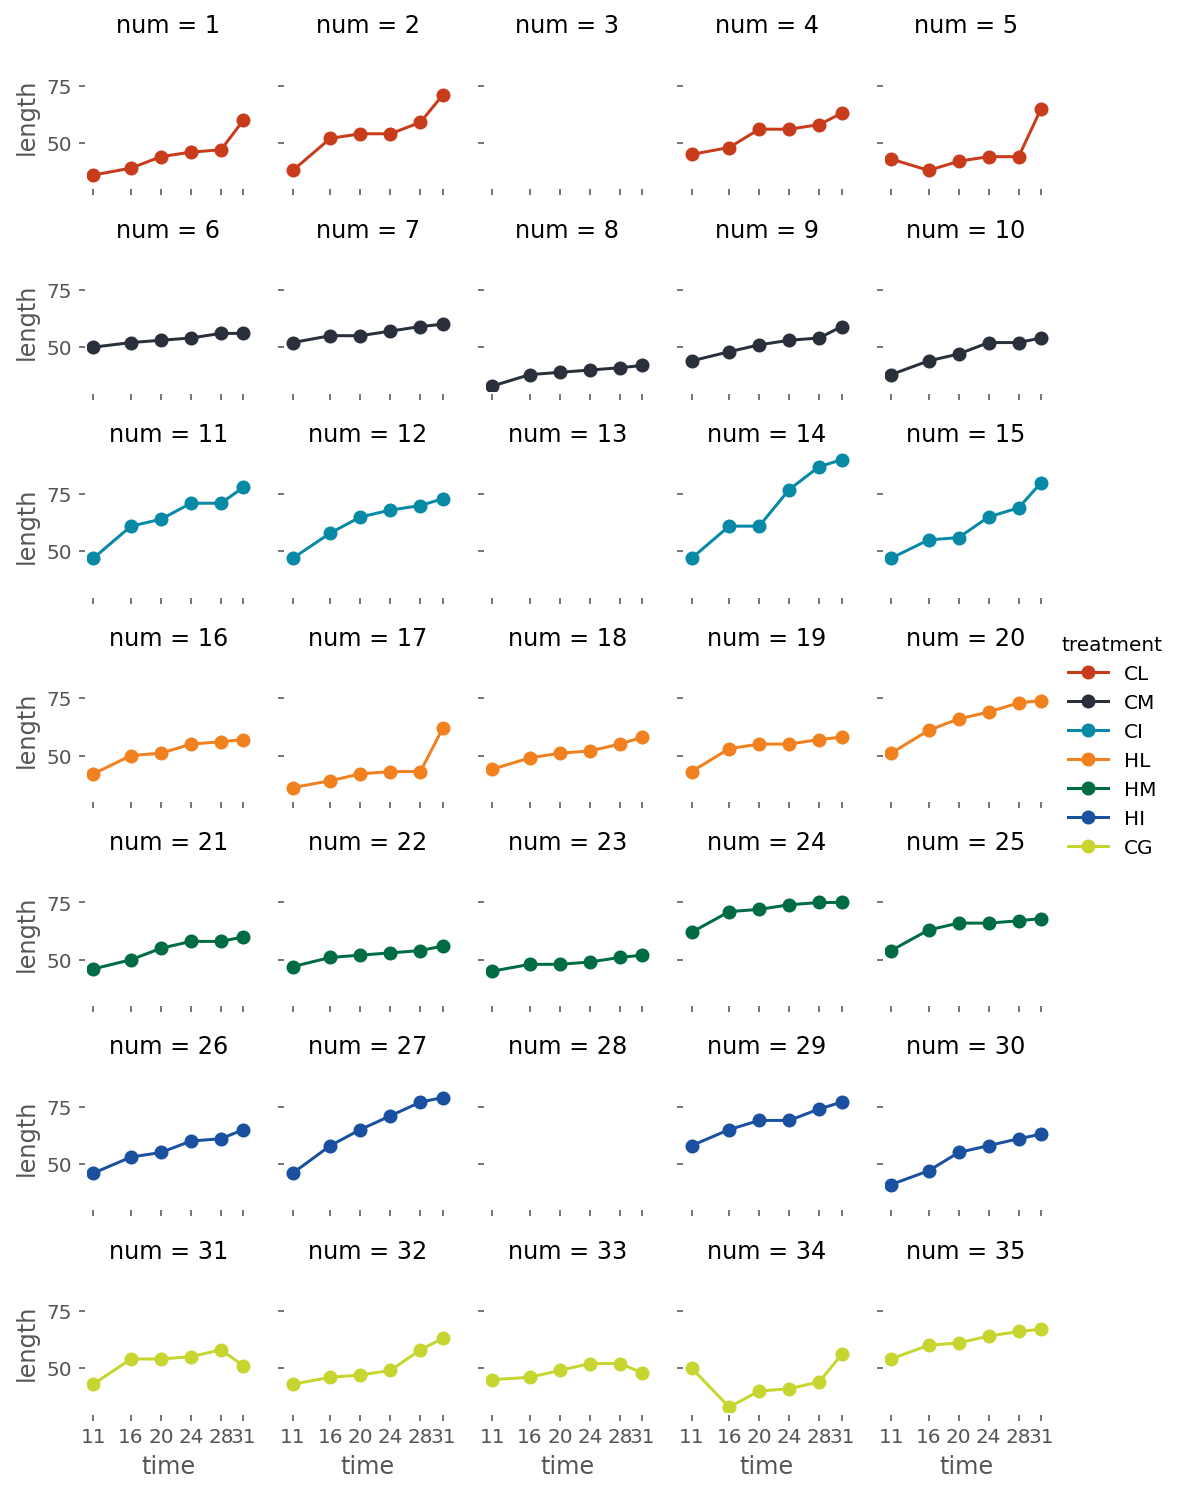

In [7]:
def plot_facegrid_by_time(data, y):
    """绘制数据某变量随时间变化
    data: 检查的数据集
    y: 随时间变化的某变量
    """
    grid = sns.FacetGrid(
        data,
        col='num',
        hue='treatment',
        col_wrap=5,
        height=1.5
    )

    grid.map(plt.plot, "time", y, marker="o")
    grid.set(
        xticks=merged_data['time'].unique(),
    )
    grid.add_legend()
    return 
    
    
# 匍匐茎总长度随时间的变化
plot_facegrid_by_time(cleaned_data, 'length')

可以看到匍匐茎长度基本上都是伸长生长的趋势，数据质量不错，仅有少数无法轻易认定情况的突变值。大部分植株的匍匐茎都在40-60之间变化，但重度沙埋下的两组实验上升趋势明显，基本上变化趋势走到了70以上。

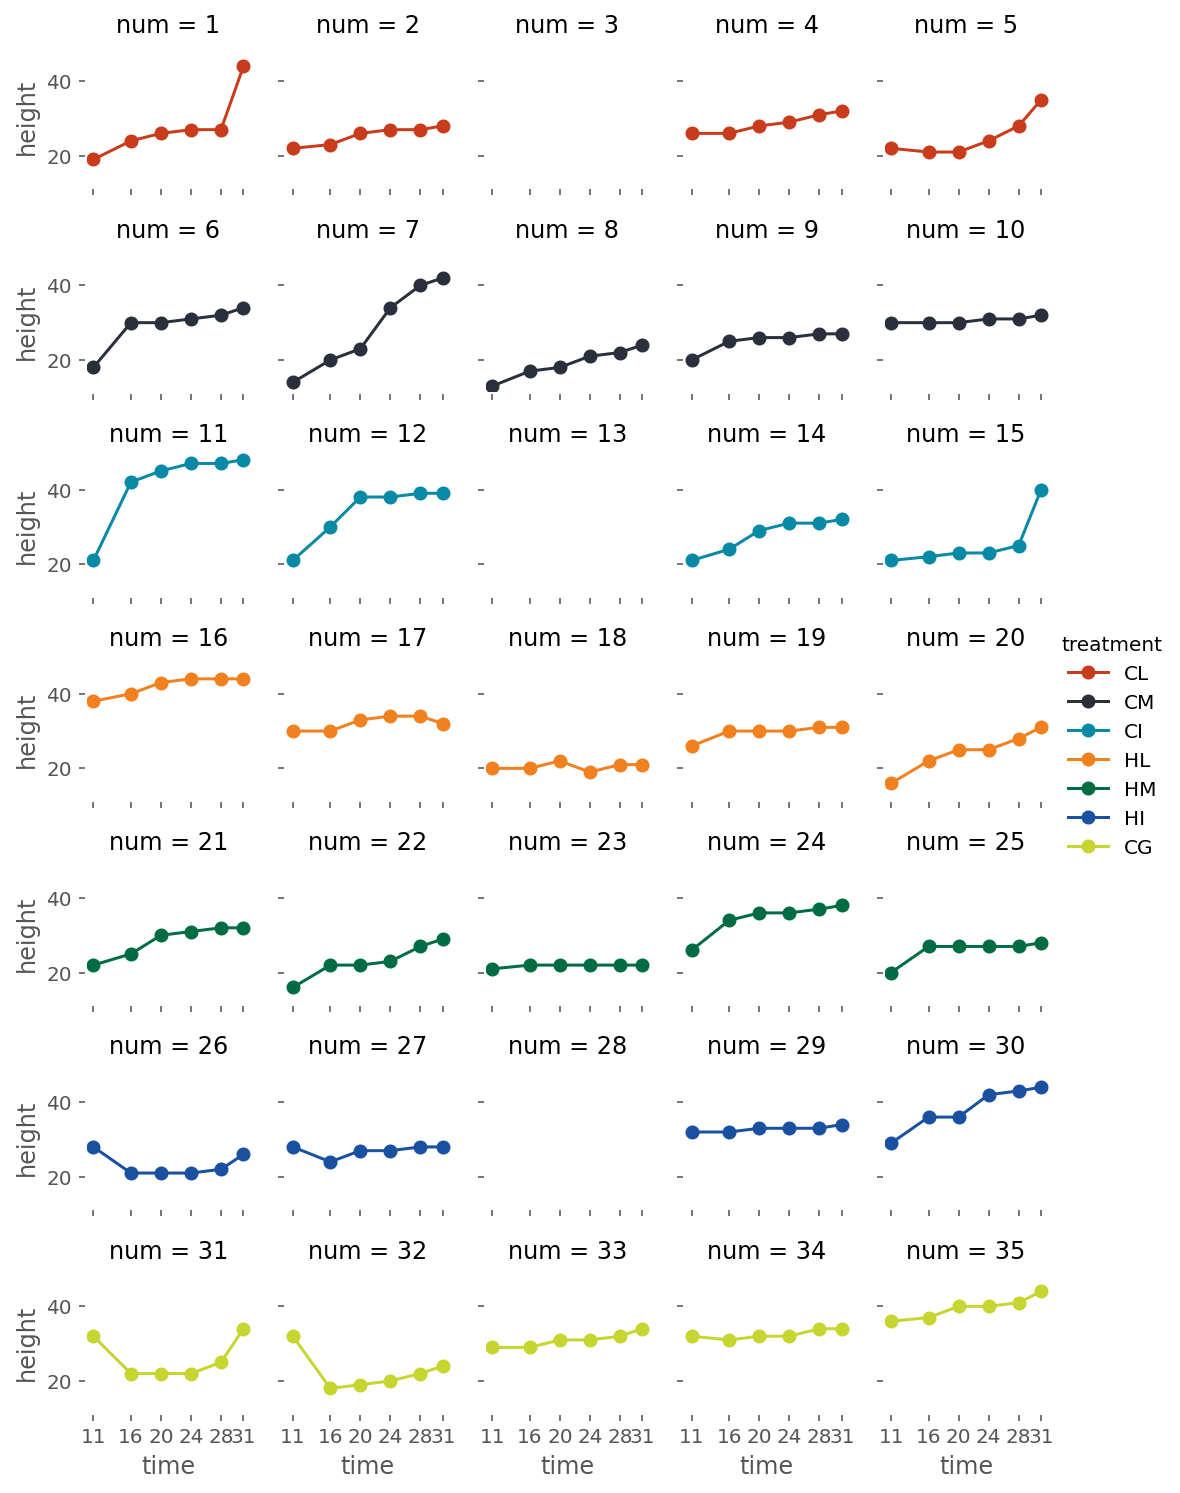

In [8]:
# 植株高度随时间的变化
plot_facegrid_by_time(cleaned_data, 'height')

株高的数据质量差的有点多，排除存在的突变点之后，基本上都是保持水平的趋势，在20-40之间变化。

## 修改主要结果1. 沙埋对植株生长对影响

现在只讨论迎风坡的植株生长对沙埋协迫的响应。生长包括垂直方向对株高生长，以及水平方向对匍匐茎伸长生长。由于讨论的是“生长”，所以这次修改中，强调时间与处理的混合作用。

为了观察两因素的混合作用，进行重复测量的方差分析，以观察组内（时间）和实验设计（株高、或者匍匐茎长）随时间变化的显著性。

[有关重复测量的方差分析的详细解释可以看这篇文章](https://baijiahao.baidu.com/s?id=1660870267715054749&wfr=spider&for=pc)

简单来说，重复测量的方差分析，应用于对同一个样本进行多次测量对实验设计，在本研究中即对老鼠楽植株进行重复测量。
因为重复测量对不同次数（通常是在不同时间下测量）之间存在自相关性，所以重复测量对方差分析考虑并排除了这种自相关对显著性判断的影响。
此外，重复测量的方差分析还有实验组和对照组（这里是沙埋组和空白对照组），两者同时进行重复测量，看看进行处理与否对植株对生长是否有、在什么时间有显著影响。

完全重度沙埋（complete intense sand burial）与空白对照之间的对比图：


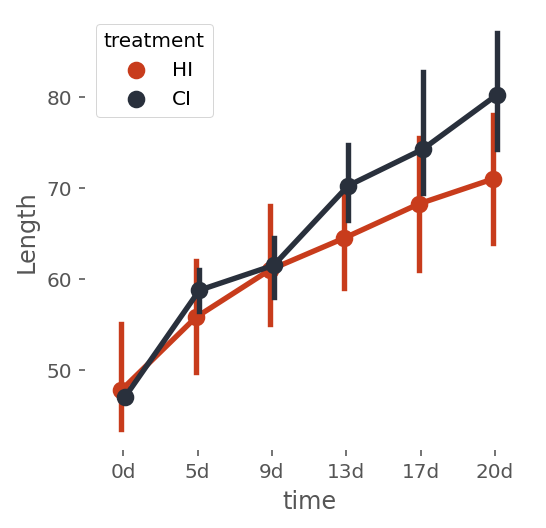

In [9]:
# 选择两组比较对实验数据
def select_compare_data(treatment, data=cleaned_data):
    """
    按照处理类型选择数据以进行分析
    treatment: 需要进行对比的数据，列表或者单独某个处理（和空白进行对照）
    data: 输入的总体清理后数据
    """
    if type(treatment) is str:
        use_data = data[(data['treatment'] == 'CG') | (data['treatment'] == treatment)]
    else:
        use_data = pd.DataFrame()
        for treat in treatment:
            mask = data['treatment'] == treat
            use_data = use_data.append(data[mask])
    return use_data


# 将两组选择的数据进行对比作图
def plot_growth_by_time(data, y, ax=False, legend=False, colors=nature_colors.values()):
    """将制定的数据，指定的因变量，绘制随时间的变化曲线
    """
    palette = sns.color_palette(colors)
    if not ax:
        fig, ax = plt.subplots(1, figsize=(4, 4))
    artist = sns.pointplot(
        data = data,
        x = 'time',
        y = y,
        hue = 'treatment',
        dodge = True,
        ax = ax,
        alpha=0.8,
        palette=palette
    )
    
    ax.set_ylabel(y.title())
    time_list = data.time.unique()
    ax.set_xticklabels(["{:.0f}d".format(time - time_list[0]) for time in time_list])
    ax.spines['bottom'].set_visible(True)
    return artist
    
print("完全重度沙埋（complete intense sand burial）与空白对照之间的对比图：")
test_data = select_compare_data(['HI', 'CI'])
plot_growth_by_time(test_data, 'length')
plt.show();

在可视化对比的基础上，再进行重复测量方差分析，检验这种差异是不是数学上显著的

In [10]:
import pingouin as pg

def get_interact_p(data, y, print_table=False, **kargs):
    """查看数据在不同时间的交互作用显著性
    data: 使用的原始数据
    y: 查看的变量
    print_table: 是否打印显著性交互作用表
    return: 返回这个变量随时间的p-unc值序列
    """
    posthocs = pg.pairwise_ttests(
        dv = y,
        within = 'time',
        between = 'treatment',
        subject = 'num',
        data = data,
        marginal=True,
        **kargs
    )
    if print_table:
        pg.print_table(posthocs)
        
    interact_data = posthocs[posthocs['Contrast'] == 'time * treatment']
    time = interact_data['time'].values
    p_corr = 'p-corr' if 'padjust' in kargs.keys() else 'p-unc'
    p_values = interact_data[p_corr].values
    return pd.Series(p_values, index=time)

get_interact_p(test_data, 'length', print_table=True);


POST HOC TESTS

Contrast          time    A     B     Paired    Parametric         T    dof  Tail         p-unc     BF10    hedges
----------------  ------  ----  ----  --------  ------------  ------  -----  ---------  -------  -------  --------
time              -       11.0  16.0  True      True          -8.540  7.000  two-sided    0.000  419.626    -1.803
time              -       11.0  20.0  True      True          -9.951  7.000  two-sided    0.000  966.601    -2.589
time              -       11.0  24.0  True      True          -9.075  7.000  two-sided    0.000  582.976    -3.421
time              -       11.0  28.0  True      True          -8.234  7.000  two-sided    0.000  344.923    -3.279
time              -       11.0  31.0  True      True          -9.594  7.000  two-sided    0.000  790.518    -3.827
time              -       16.0  20.0  True      True          -3.742  7.000  two-sided    0.007    8.415    -0.691
time              -       16.0  24.0  True      True          -

经过试验，这两组处理之间对生长对影响是不显著的：

- 根据Contrast列，time * treatment 指的是试验处理和时间变化带来的交互效应（本实验中即沙埋处理和沙埋后生长时间的共同作用）。
- 根据A，B，可以看到是那两个组进行比较，该表展示的是 Complete Intense（CI）沙埋 和 半埋重度 Half Intense（HI）之间的对比。
- 根据 time 列可以看到发生对比的时间，根据 p-unc 列可以看到发生对比的时间下，两组植株的生长之间是否差异显著。

解读该表结果，如果以0.05为显著性阈值，那么在沙埋（11号）后的16号、20号、24号、28号、31号，两组植株的生长过程中，其匍匐茎总长度没有显著差异。

接下来将类似的技术应用于所有沙埋处理组进行对比。

### 两两和空白对照进行对比

上述技术能够对比两组植株之间生长过程是否有显著差异，因为所有对沙埋实验设计都主要和空白对照组进行对比。所以迅速对所有实验组和空白组之间进行对比。

In [11]:
def compare_holistic_sig_one_by_one(test_variables, **kargs):
    treatments = cleaned_data['treatment'].unique().tolist()
    treatments.remove('CG')
    mixed_anova = pd.DataFrame(index=test_variables)

    for treatment in treatments:
        for variable in test_variables:
            data = select_compare_data(treatment)
            data = data[data['time']>11]  # 只看经过沙埋处理后的对比，而不看第一天选择植株时的差异
            p_corr = 'p-corr' if 'padjust' in kargs.keys() else 'p-unc'
            try:
                anova = data.mixed_anova(dv = variable, within='time', between='treatment', subject='num')
                # 这里看一下高度的数据
    #             if variable == 'height':
    #                 print("Results from {} and {}".format(treatment, variable))
    #                 test = get_interact_p(data, 'height', print_table=True)
                mixed_anova.loc[variable, treatment] = anova.loc[2, p_corr]
            except:
                mixed_anova.loc[variable, treatment] = np.nan

    # 经测试，在运行不定根的变化的时候，会因为过多的 0 值而无法比较，有时候抛出警告，这里为了美观，不再显示警告
    # 警告信息：nvalid value encountered in double_scalars  fval = ms_with / ms_reswith
    import warnings
    warnings.filterwarnings("ignore")
    print("各个测量变量、各个沙埋处理之后，对老鼠楽生长影响的显著性表：")
    return mixed_anova


test_variables = ['length', 'height']
compare_holistic_sig_one_by_one(test_variables)

各个测量变量、各个沙埋处理之后，对老鼠楽生长影响的显著性表：


,CL,CM,CI,HL,HM,HI
length,0.021850,0.847383,0.028097,0.896822,0.600841,0.482692
height,0.376591,0.695932,0.556944,0.078887,0.256560,0.578035


**根据实验结果，可以得到以下主要认识：**

- 对于匍匐茎长来说，只有HI，CI出现了时间+沙埋的显著交互效应，经过进一步数据检验
- 株高全部没有显著的交互效应，说明沙埋对株高生长无显著影响。

### 显著差异出现的时间
**进一步探索，显著的交互效应出现在何时，并通过可视化展示：**

各实验组植株的匍匐茎长与空白对照之间的差值对比：


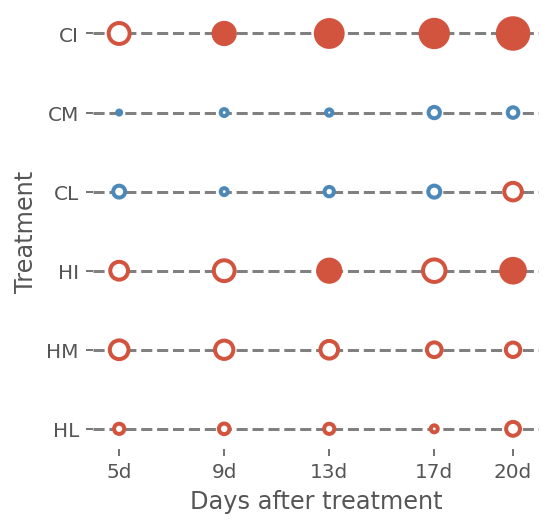

In [12]:
# 沙埋处理后，随时间变化的植株生长显著性水平
def plot_grid_differences_and_p(variable, scale=10, ax=False, legend=False, treatments='all', **kargs):
    if not ax:
        fig, ax = plt.subplots(1, figsize=(4, 4))
    time_list = cleaned_data.time.unique()
    control_group_data = cleaned_data[cleaned_data['treatment'] == 'CG']


    def mean_by_time(data, t, y):
        """根据日期选择数据，计算平均值
        """
        return data[data['time'] == t][y].mean()

    def judge_colors(diff, p_unc, two_colors=['#4c89b9', '#d2543e']):
        edgecolors, facecolors = [], []
        for i in range(len(diff)):
            if diff[i] < 0:
                edgecolor = two_colors[0]
                if p_unc.iloc[i] <= 0.1:
                    facecolor = '#C4D9E8'
            else:
                edgecolor = two_colors[1]
                if p_unc.iloc[i] <= 0.1:
                    facecolor = '#EFC4BD'
            if p_unc.iloc[i] <= 0.05:
                facecolor = edgecolor
            else:
                facecolor = 'white'
            edgecolors.append(edgecolor)
            facecolors.append(facecolor)
        return edgecolors, facecolors
    
    
    if treatments == 'all':
        treatments = ['HL', 'HM', 'HI', 'CL', 'CM', 'CI']

    differences_table = pd.DataFrame(index=time_list)
    for i, treatment in enumerate(treatments):
        y = np.full(len(time_list), i)
        tmp_data = cleaned_data[cleaned_data['treatment'] == treatment]
        differences = [mean_by_time(tmp_data, date, variable) - mean_by_time(control_group_data, date, variable) for date in time_list]
        p_unc = get_interact_p(data=select_compare_data(treatment), y=variable, **kargs)
        edgecolors, facecolors = judge_colors(differences, p_unc)
        ax.scatter(x=time_list, y=y, s=np.abs(differences)*scale, edgecolor=edgecolors, color=facecolors, linewidths=2, zorder=1)
        differences_table[treatment] = differences

    # 美观作图
    ax.yaxis.grid(color='gray', linestyle="--", linewidth=1.5, zorder=0)  #网格线
    ax.set_yticks(np.arange(len(treatments)))
    ax.set_yticklabels(treatments)
    ax.set_xticks(time_list)
    ax.set_xlim(15, 32)
    ax.set_xticklabels(["{:.0f}d".format(time - time_list[0]) for time in time_list])
    [ax.spines[spine].set_visible(False) for spine in ['top', 'bottom', 'left', 'right']]
    ax.set_xlabel('Days after treatment')
    ax.set_ylabel('Treatment')
    
    # 控制图例
    sig_positive = plt.Line2D((0,1), (0,0), color='gray', marker='o', linestyle='--', mec='#d2543e', mfc='#d2543e', label='Sig. Positive')
    nonsig_positive = plt.Line2D((0,1), (0,0), color='gray', marker='o', linestyle='--', mec='#d2543e', mfc='white', label='Non-Sig. Positive')
    sig_negative = plt.Line2D((0,1), (0,0), color='gray', marker='o', linestyle='--', mec='#4c89b9', mfc='#4c89b9', label='Sig. Negative')
    nonsig_negative = plt.Line2D((0,1), (0,0), color='gray', marker='o', linestyle='--', mec='#4c89b9', mfc='white', label='Non-Sig. Negative')
    
    if legend:
        ax.legend(handles = [sig_positive, nonsig_positive, sig_negative, nonsig_negative],
                  bbox_to_anchor=(1, 0), loc=3, borderaxespad=0, ncol=1)
    return differences_table
    

print("各实验组植株的匍匐茎长与空白对照之间的差值对比：")
differences = plot_grid_differences_and_p('length')
plt.show()

上图中点对大小代表实验组（沙埋的）老鼠楽与空白对照组（未经过沙埋的）老鼠楽匍匐茎长的差值绝对值大小。
如果该差值是负数，则点为蓝色，如果该差值为正数，则点为红色。如果该时间点差异显著，则为实心点，否则为空心点。

可得到以下主要认识：
- 确如前文的实验结果那样，只有HI和CI两组处理出现了显著差异，而且这个差异都是实验组的茎长 > 对照组的茎长，说明HI和CI的沙埋能够促进植株显著增加匍匐茎伸长速度。
- HI（重度半埋）的增强作用比CI（重度全埋）要低，而且重度全埋的显著差异出现时间点（沙埋后9天）也早于重度半埋（沙埋后13天）
- 重度半埋在第17天的时候差异还变得不显著了，（其实在9天的时候显著性水平也在0.05阈值边缘）。

加上最开始我们对比过 HI 和 CI 之间，两者的差异是不显著的，还可以额外得到以下认识：
- 只有重度沙埋（即沙埋到匍匐茎顶端）能够促进匍匐茎伸长生长，沙埋厚度越大促进作用越强，和空白对照相比出现显著差异但时间越早。
- 但半埋和全埋之间对比的话，两组植株但生长过程差异并不显著，因此重度沙埋（沙埋到匍匐茎顶端）才是促进植株伸长生长的关键。

### 不同实验组对生长促进的比例

In [13]:
# 看看 HI 和 CI 分别促进植株生长了多少
mean_total_length_of_cg = select_compare_data('CG').groupby('time')['length'].mean()
diff_precentage = pd.DataFrame()
for col in ['HI', 'CI']:
    diff_precentage[col] = np.round(differences[col] / mean_total_length_of_cg * 100, 2)
    
print("不同的沙埋处理下，每次测量相对于空白对照组茎长增加的百分比：")
diff_precentage.astype('str') + '%'

不同的沙埋处理下，每次测量相对于空白对照组茎长增加的百分比：


,HI,CI
11.0,1.6%,0.0%
16.0,16.63%,22.91%
20.0,21.51%,22.51%
24.0,23.56%,34.58%
28.0,22.75%,33.54%
31.0,24.56%,40.79%


植株进行沙埋后，在20d的沙埋结束后，重度半埋和重度全埋分别可以让植株生长相对于对照组加快 24.56% 和 40.79%

### 茎的比例分配

不同沙埋处理下，匍匐茎的三段长（基部、中部、顶端）随时间的比例变化：


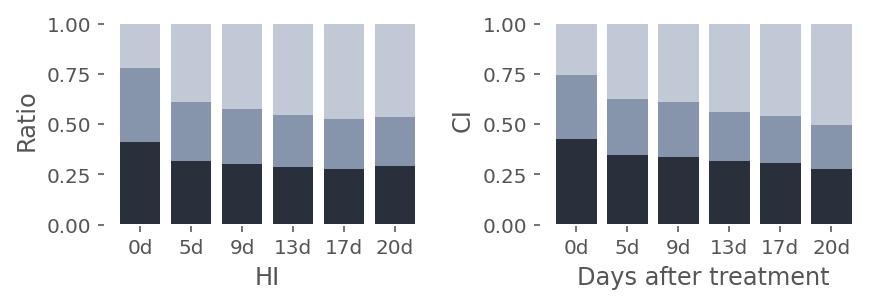

In [14]:
# 茎的三段分配比例作图函数
def plot_bar_sections(treatment, ax=False, legend=False):
    colors = ['#29303C', '#8694AC', '#C2C9D6']
    legends = []
    if not ax:
        fig, ax = plt.subplots(figsize=(4, 2))
        
    sections = ['base', 'middle', 'top']
    test_data = select_compare_data([treatment])
    sections_data = test_data.groupby(['time']).mean().loc[:, sections]
    tmp_data = (sections_data.T / sections_data.T.sum()).T

    bottom = np.zeros(len(tmp_data))
    for i, col in enumerate(tmp_data):
        artist = ax.bar(x=np.arange(len(tmp_data)), bottom=bottom, height=tmp_data[col], label=col, color=colors[i])
        bottom += tmp_data[col].values
        legends.append(artist)
        
    ax.set_ylabel("Ratio")
    ax.set_xlabel('Days after treatment')
    time_list = tmp_data.index
    ax.set_xticks(range(len(time_list)))
    ax.set_xticklabels(["{:.0f}d".format(time - time_list[0]) for time in time_list])
    if legend:
        ax.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0, ncol=1, title='Sections')
        
    return tmp_data
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2), constrained_layout=True)
hi_top_ratio = plot_bar_sections('HI', ax=ax1)
ci_top_ratio = plot_bar_sections('CI', ax=ax2)
ax1.set_xlabel("HI")
ax2.set_ylabel("CI")
print("不同沙埋处理下，匍匐茎的三段长（基部、中部、顶端）随时间的比例变化：")
plt.show();

In [15]:
hi_top_ratio

,base,middle,top
time,,,
11.0,0.412181,0.366906,0.220912
16.0,0.318386,0.291480,0.390135
20.0,0.299180,0.274590,0.426230
24.0,0.286822,0.259690,0.453488
28.0,0.278388,0.249084,0.472527
31.0,0.292254,0.242958,0.464789


可以看出，伸长生长主要发生在匍匐茎顶端，其长度占比逐渐增加，而基部和中部的占比则成比例地下降。

### 最终可视化

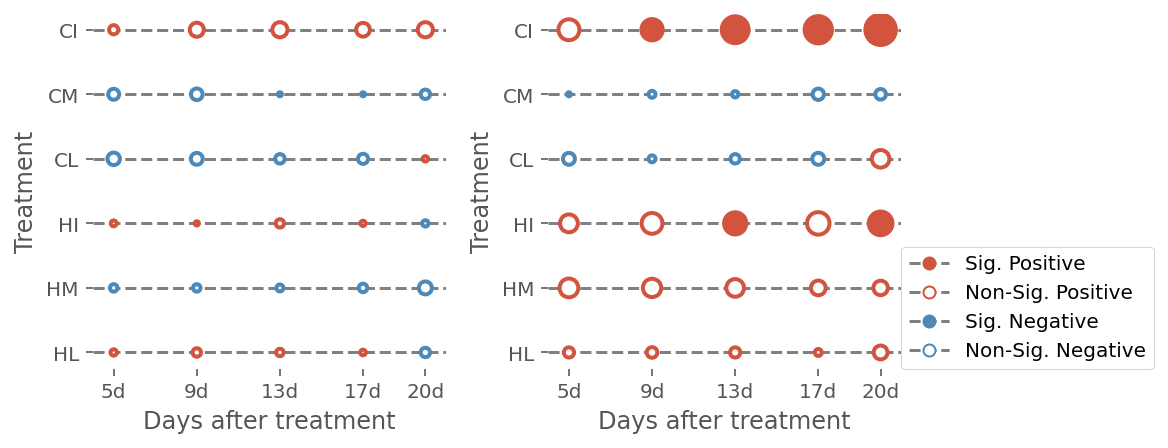

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), constrained_layout=True)
plot_grid_differences_and_p(variable='height', ax=ax1)
plot_grid_differences_and_p(variable='length', ax=ax2, legend=True)

plt.savefig('../figs/grid_differences.jpg', dpi=300)
plt.show();

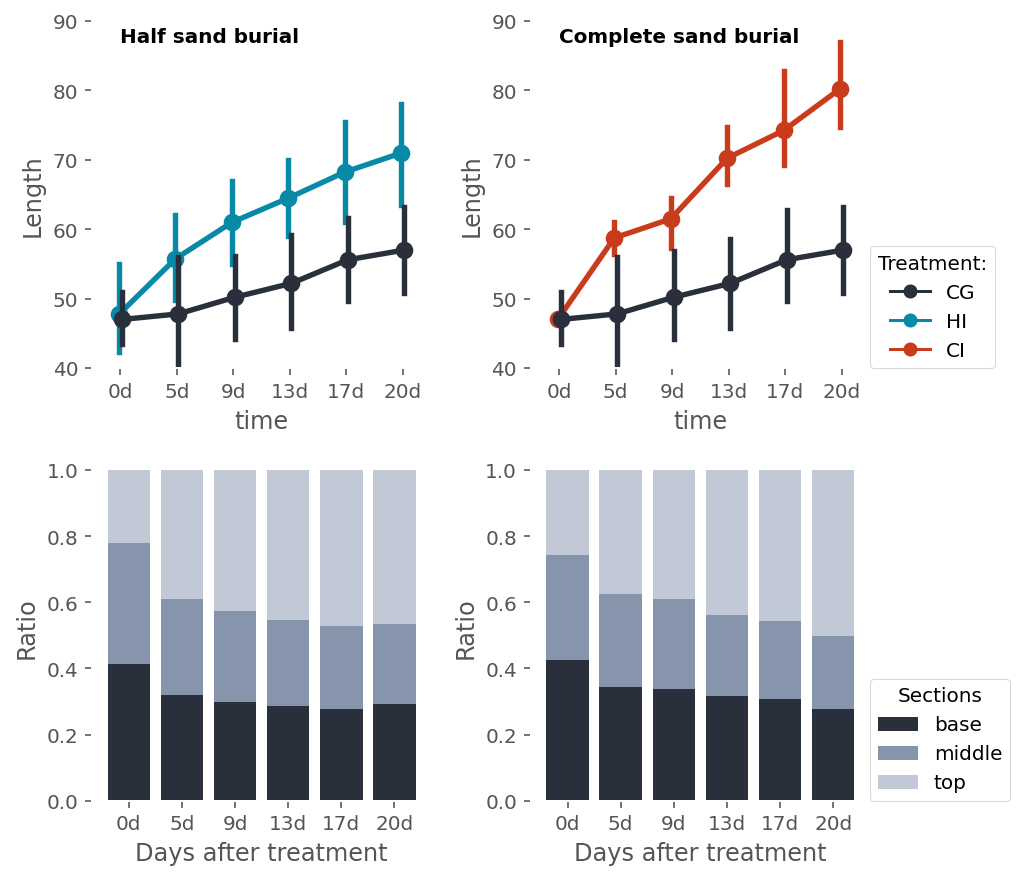

In [17]:
# 尝试另一种组合方式
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 6), constrained_layout=True)
plot_growth_by_time(data=select_compare_data('HI'), y='length', ax=ax1, colors=["#0889a6", "#29303c"])
plot_growth_by_time(data=select_compare_data('CI'), y='length', ax=ax2, colors=["#c83c1c", "#29303c"])
plot_bar_sections("HI", ax=ax3, legend=False)
plot_bar_sections("CI", ax=ax4, legend=True)
ax1.set_ylim(ax2.get_ylim())

hi = plt.Line2D((0,1), (0,0), color='#0889a6', marker='o', mec='#0889a6', mfc='#0889a6', label='HI')
cg = plt.Line2D((0,1), (0,0), color='#29303c', marker='o', mec='#29303c', mfc='#29303c', label='CG')
ci = plt.Line2D((0,1), (0,0), color='#c83c1c', marker='o', mec='#c83c1c', mfc='#c83c1c', label='CI')
ax1.get_legend().remove()
ax2.legend(handles=[cg, hi, ci], bbox_to_anchor=(1, 0), loc=3, borderaxespad=0, ncol=1, title='Treatment:')
for ax in [ax1, ax2]:
    ax.set_ylim(40, 90)
ax1.text(0, 87, "Half sand burial", ha='left', weight='bold')
ax2.text(0, 87, "Complete sand burial", ha='left', weight='bold')

plt.savefig('../figs/growth_process.jpg', dpi=300)
plt.show();

### 结果1分析：

- 不同的沙埋处理下的老鼠楽株高的生长过程与空白对照之间没有显著差异（图1A），但沙埋对老鼠楽匍匐茎的伸长生长产生了显著影响（图1B）。
- 重度半埋和重度全埋均对植株匍匐茎的伸长生长产生了显著的促进作用，其中重度全埋的显著作用在沙埋后9天时已经出现，重度半埋的显著作用在13天后出现（图1B）。
- 不仅时间上显著效应出现的早，全埋对老鼠楽生长的促进作用也比半埋影响更大，茎长在实验结束后显著增长了24.56%，而半埋显著增长了40.79% （图2A-B）。
- 其伸长生长过程都在不断增加顶端1/3长度所占的比例，而基部长度占比和中段的长度占比均匀下降（图2C-D）。

## 不定根对比

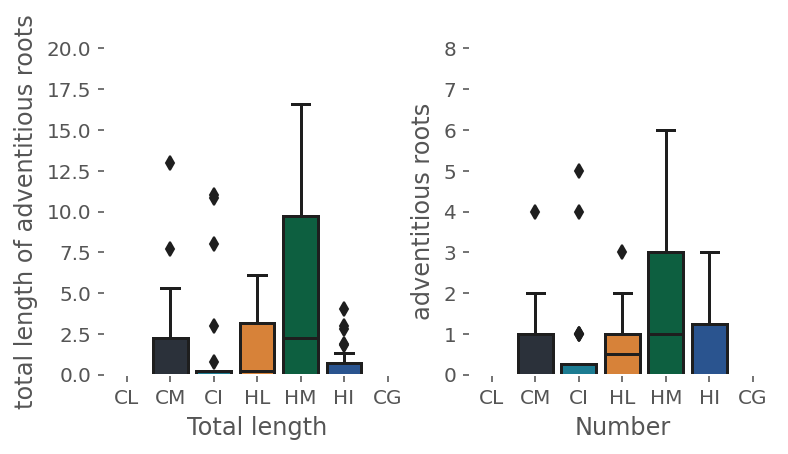

In [18]:
# 不定根的数量和总长度
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
sns.boxplot(data=cleaned_data, x='treatment', y='total length of adventitious roots', ax=ax1)
sns.boxplot(data=cleaned_data, x='treatment', y='adventitious roots', ax=ax2)
ax1.set_ylim(0, 20)
ax2.set_ylim(0, 8)
ax1.set_xlabel('Total length')
ax2.set_xlabel('Number')
plt.show();

不定根可以增加植株的水分获得能力，或者起到固定植株的作用。

根据上图，空白对照组植株在最初清除所有不定根之后，试验全程没有新的不定根生成，但除了CL实验组之外，大多数但沙埋实验植株都在实验过程中出现了不定根。

各个测量变量、各个沙埋处理之后，对老鼠楽生长影响的显著性表：


,CL,CM,CI,HL,HM,HI
total length of adventitious roots,NaN,0.365888,0.085293,0.486272,0.020534,0.243037
adventitious roots,NaN,0.198322,0.075412,0.056905,0.140957,0.044342


不同时间点测量，实验组和空白对照组之间不定根相关差异的显著性变化


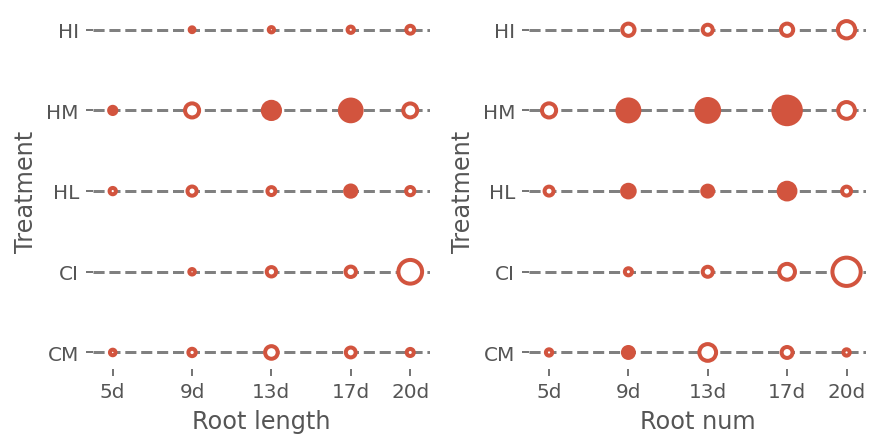

In [19]:
# 不定根数量、总长度随着时间变化，与空白对照组之间对比的显著性
test_variables = ['total length of adventitious roots', 'adventitious roots']
compare_holistic_sig_one_by_one(test_variables)

treatments = cleaned_data['treatment'].unique().tolist()
treatments.remove('CG')
treatments.remove('CL')
mixed_anova = pd.DataFrame()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
diff_root_length = plot_grid_differences_and_p(variable='total length of adventitious roots', ax=ax1, treatments=treatments)
diff_root_num = plot_grid_differences_and_p(variable='adventitious roots', ax=ax2, scale=50, treatments=treatments)
xlabel1 = ax1.set_xlabel('Root length')
xlabel2 = ax2.set_xlabel('Root num')

print('不同时间点测量，实验组和空白对照组之间不定根相关差异的显著性变化')
plt.show()

尽管大多数实验组都出现了不定根，但不定根但生长过程与空白对照组相比鲜有显著，仅HM组在总长度上显著，HI组在不定根数量上显著。

但随着时间不同进行对比，还是有些特别但时间点上出现了不定根但显著差异。但仅在HM，HL，HI三组上出现一定但普遍性。可能意味着半埋对不定根生长更具有促进作用。

这主要是因为标准误比较大，各组都还是有植株没有生成不定根的，这可能说明影响不定根生成的因素比较复杂。

但基于规律出现在实验组具有整体性，我们还是可以说，沙埋对不定根对生成有促进作用。

In [20]:
# 这个代码可以展示不定根的数量的大概情况，如果需要，就可以使用。
# 如果要展示不定根的长度，则把变量y改为 'total length of adventitious roots'
# plot_facegrid_by_time(data=cleaned_data, y='adventitious roots')

## 植株干重对比

### 干重数据清洗

干重数据的原始数据与沙埋数据来源不同，是我处理的，但是录入数据在硬盘里被毁掉了，所以现在只能读取均值+-标准差的数据集进行处理。

In [21]:
# 读取干重数据

weight = pd.read_excel("../data/植株干重.xlsx").drop(0)
for col in weight:
    weight[col] = fill_col_by_last_value(weight[col])
    
columns_name = [
    'bur_y', 'bur_x',
    'base root', 'base stem', 'base leaf',
    'middle root', 'middle stem', 'middle leaf',
    'top root', 'top stem', 'top leaf'
]

weight = weight.rename({x: columns_name[i] for i, x in enumerate(weight.columns)}, axis=1)
weight.loc[1, 'bur_x'] = 'Control group'
weight['treatment'] = weight['bur_y'].str[0] + weight['bur_x'].str[0]
weight.replace({'CC': 'CG'}, inplace=True)

weight  # 清洗好的数据

,bur_y,bur_x,base root,base stem,base leaf,middle root,middle stem,middle leaf,top root,top stem,top leaf,treatment
1,Control group,Control group,0.1±0.2,20.2±4.1,18.2±7.4,0.0±0.0,13.7±3.7,16.4±6.8,0.0±0.0,12.6±7.7,18.5±6.0,CG
2,Half sand burial,Light,0.0±0.0,16.6±2.4,14.1±4.2,0.0±0.0,19.4±4.7,21.6±5.0,0.0±0.0,8.2±3.3,19.8±7.5,HL
3,Half sand burial,Moderate,1.4±1.3,22.1±1.8,20.3±4.9,0.1±0.1,12.5±3.6,16.2±1.7,0.0±0.0,8.1±2.2,18.9±8.1,HM
4,Half sand burial,Intense,0.6±0.5,21.0±3.9,18.1±2.9,0.0±0.0,10.3±4.0,17.9±6.7,0.0±0.0,8.3±2.6,23.4±7.4,HI
5,Complete sand burial,Light,0.2±0.4,14.1±5.7,19.3±6.5,0.0±0.0,12.0±1.4,22.5±2.3,0.0±0.0,8.3±4.1,23.3±7.4,CL
6,Complete sand burial,Moderate,1.8±1.6,16.2±4.2,13.3±7.1,0.0±0.0,11.7±5.2,23.4±13.9,0.0±0.0,6.8±2.3,26.5±8.7,CM
7,Complete sand burial,Intense,0.9±1.4,21.7±3.9,22.6±5.7,0.1±0.3,11.1±2.8,19.0±5.0,0.0±0.0,7.5±2.7,16.6±6.0,CI


### 根的干重分布

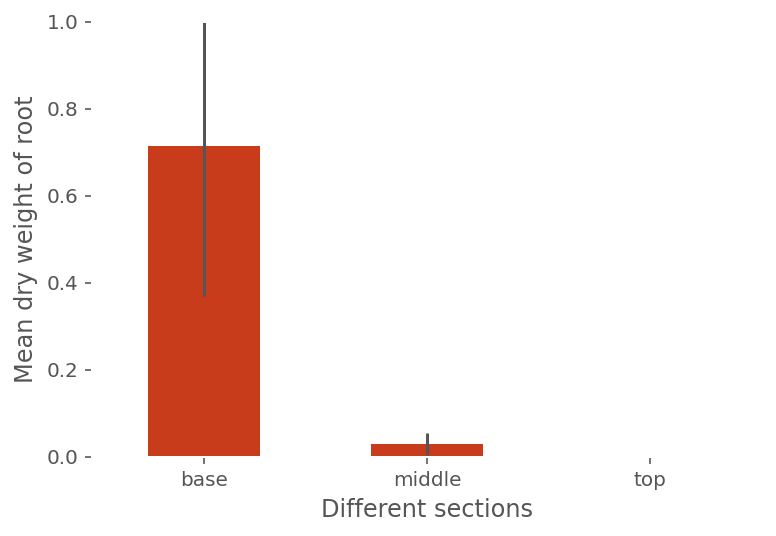

In [22]:
def get_section_by_position(treatment, position, section):
    tmp_data = weight[weight['treatment'] == treatment].iloc[0]
    splited = tmp_data.iloc[2:2+9].str.split('±')
    mean, ste = splited.str[0].astype(float), splited.str[1].astype(float) / np.sqrt(5)
    
    if section == 'all':
        sections = ['base', 'middle', 'top']
        index = ['{} {}'.format(s, position) for s in sections]
        position_mean = mean.loc[index].sum()
        position_ste = ste.loc[index].sum()
    else:
        index = '{} {}'.format(section, position)
        position_mean = mean.loc[index]
        position_ste = ste.loc[index]
    return position_mean, position_ste


def plot_position_weight(position, ax=False):
    """植株某部位干重作图，对比其在不同部位的变化
    """
    treatments = cleaned_data.treatment.unique()
    sections = ['base', 'middle', 'top']

    mean_df, ste_df = pd.DataFrame(index=treatments), pd.DataFrame(index=treatments)
    for treatment in treatments:
        for section in sections:
            mean, ste = get_section_by_position(treatment, position, section)
            mean_df.loc[treatment, section] = mean
            ste_df.loc[treatment, section] = ste

    if not ax:
        fig, ax = plt.subplots()

    mean_df.mean().plot.bar(yerr=ste_df.mean(), ax=ax, rot=0)
    ax.set_ylabel("Mean dry weight of root")
    ax.set_xlabel("Different sections")
    ax.set_ylim(0, 1)
    return mean_df


mean_root_weights = plot_position_weight(position='root')
plt.show();

In [23]:
mean_root_weights.sum() / mean_root_weights.sum().sum()

base      0.961538
middle    0.038462
top       0.000000
dtype: float64

不难看出，不定根几乎全部$(96\%)$分布在植株的基部，中段和顶端几乎没有不定根。

### 可视化

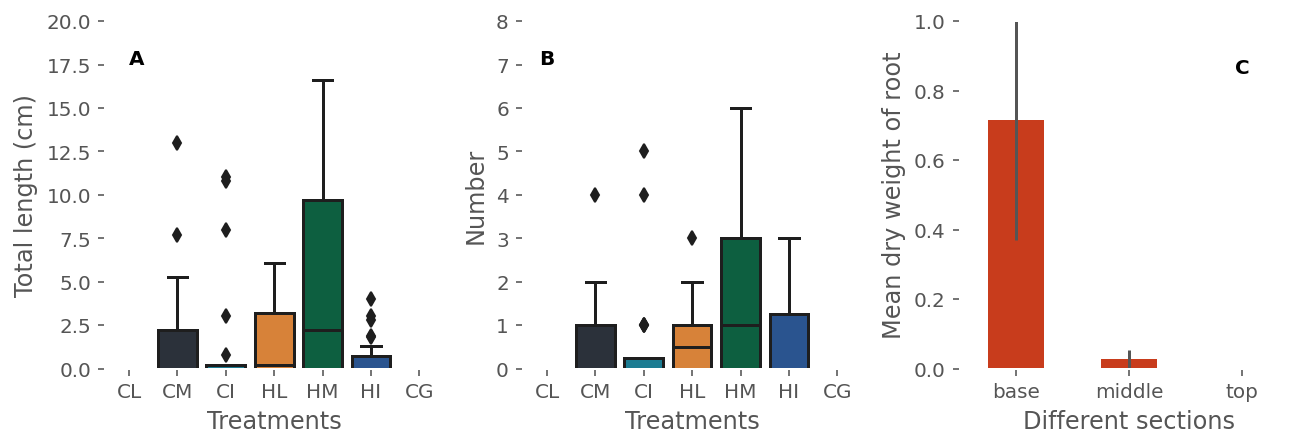

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

sns.boxplot(data=cleaned_data, x='treatment', y='total length of adventitious roots', ax=ax1)
sns.boxplot(data=cleaned_data, x='treatment', y='adventitious roots', ax=ax2)
ax1.set_ylim(0, 20)
ax2.set_ylim(0, 8)
ax1.set_ylabel('Total length (cm)')
ax2.set_ylabel('Number')
ax1.set_xlabel('Treatments')
ax2.set_xlabel('Treatments')

ax1.text(0., 17.5, 'A', weight='bold')
ax2.text(0., 7, 'B', weight='bold', ha='center')
ax3.text(2., 0.85, 'C', weight='bold', ha='center')

plot_position_weight('root', ax3)
plt.savefig('../figs/roots.jpg', dpi=300)
plt.show();

In [25]:
cleaned_data.groupby('treatment').mean()

,num,time,base,middle,top,length,height,adventitious roots,total length of adventitious roots
treatment,,,,,,,,,
CG,33,21.666667,17.009375,14.017188,20.773438,51.633333,30.366667,0.000000,0.000000
CI,13,21.666667,21.385028,16.774723,27.173582,65.333333,32.375000,1.000000,3.283333
CL,3,21.666667,17.500000,12.583333,19.958333,50.083333,26.791667,0.000000,0.000000
CM,8,21.666667,18.966667,14.566667,16.066667,49.600000,26.600000,0.500000,1.636667
HI,28,21.666667,18.988609,16.919964,25.466427,61.375000,30.333333,0.583333,0.637500
HL,18,21.666667,17.133333,16.066667,19.766667,53.333333,29.800000,0.600000,1.586667
HM,23,21.666667,16.933333,16.766667,24.500000,58.200000,26.833333,1.866667,5.053333


### 干重数据的“茎叶干重比”

茎叶干重比可以表达植株的物质分配情况，该值越高可以说明植株在这部分更倾向于生成茎，而较低则说明倾向于有更多的叶片。

我们将不同沙埋处理下，植株的茎叶干重比与空白对照组进行对比。

计算所得的标准差，[参考这个帖子里的方法](https://zhidao.baidu.com/question/118189844.html)

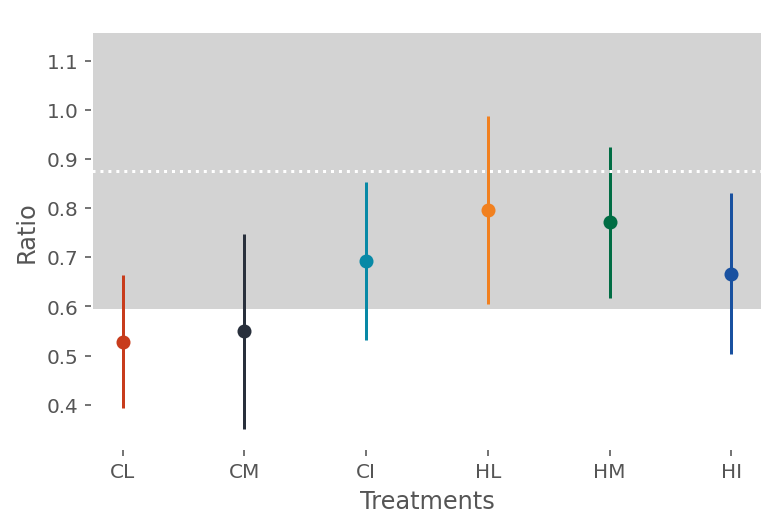

In [26]:
def get_std_after_div(a, p, b, q):
    """根据两个带误差棒的数据相除，计算所得值的误差范围
    a: 被除数的均值
    p: 被除数的标准误
    b: 除数的均值
    q: 除数的标准误
    return: z0, delta_z，相除所得数据的值和误差范围
    """
    z0 = a/b
    delta_z = ((1/b)*p+(a/b**2)*q)
    return z0, delta_z


def get_stem_leaf_ratio(section, treatment):
    
    stem_mean, stem_ste = get_section_by_position(treatment, 'stem', section)
    leaf_mean, leaf_ste = get_section_by_position(treatment, 'leaf', section)
    
    mean, ste = get_std_after_div(stem_mean, stem_ste, leaf_mean, leaf_ste)
    return mean, abs(ste)



def plot_compare_stem_leaf_ratio(section, ax=False, plot_ste=True, n=5):
    from scipy.stats import ttest_ind_from_stats as sf

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    treatments = cleaned_data.treatment.unique().tolist()
    treatments.remove('CG')
    
    mean_cg, ste_cg = get_stem_leaf_ratio(section=section, treatment='CG')
    ax.axhspan(mean_cg+ste_cg, mean_cg-ste_cg, color='lightgray', label='Standard error')
    if plot_ste:            
        ax.axhline(mean_cg, ls=':', color='white', label='CG')
    else:
        ax.axhline(mean_cg, ls=':', color='red')
        
    for i, treatment in enumerate(treatments):
        mean, ste = get_stem_leaf_ratio(section=section, treatment=treatment)
        p_value = sf(
            mean1=mean_cg, std1=ste_cg*np.sqrt(n), nobs1=n,
            mean2=mean, std2=ste*np.sqrt(n), nobs2=n
        )[1]

        if plot_ste:
            ax.errorbar(x=i, y=mean, yerr=ste, marker='o')
            if p_value <= 0.05:
                treatments[i] = treatment + "*"
        else:
            ax.scatter(x=i, y=mean, marker='o')
            
    ax.set_xticks(range(len(treatments)))
    ax.set_xticklabels(treatments)
#     ax.legend()
    return mean, ste


fig, ax = plt.subplots()
plot_compare_stem_leaf_ratio('all', ax=ax)
ax.set_xlabel("Treatments")
ax.set_ylabel("Ratio")

plt.show();

可以看到，经过沙埋后，茎叶干重比普遍相对于空白对照组的均值偏低，但整体差异不显著。

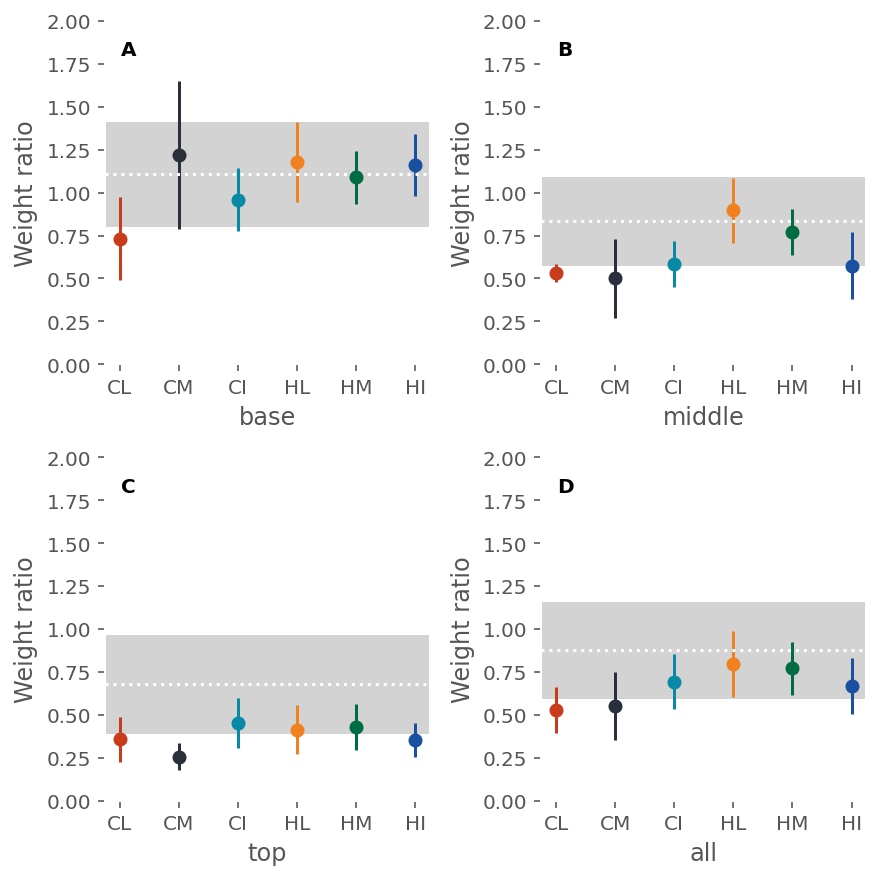

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)
labels = ['A', 'B', 'C', 'D']
sections = ['base', 'middle', 'top', 'all']
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    section = sections[i]
    plot_compare_stem_leaf_ratio(section, ax=ax, plot_ste=True)
    ax.set_xlabel(section)
    ax.set_ylim(0, 2)
    ax.set_ylabel("Weight ratio")
    ax.text(0.05, 0.90, labels[i], transform=ax.transAxes, weight='bold')
    
plt.savefig('../figs/ratio.jpg', dpi=300)
plt.show();

如果分别考察植株匍匐茎的不同段，发现在匍匐茎顶端，这个差异非常明显。

这说明沙埋能显著降低匍匐茎顶端的“茎叶干重比”。经过长时间沙埋后，植株匍匐茎顶端倾向于将更多的物质积累在的茎上，而不是叶片。

### 主要结果2分析

- 大多数的人工沙埋不同程度上促进了不定根的生成，无论是不定根数量还是总长度（Fig3）。
- 而且不定根主要分布在基部，顶端无不定根生成。
- 此外，经过20天的沙埋实验，老鼠楽植株茎和叶片的干重比例在不同程度上发生了改变。
- 相对于空白对照组来说，沙埋使得植株将干重更多分配在茎上而非叶片上，在植株的顶端尤其明显。

## 结果总结

拟从两方面阐述主要结果：

**Influence of sand burial on growth processes of S. littoreus**
- 不同的沙埋处理下的老鼠楽株高的生长过程与空白对照之间没有显著差异（图1A），但沙埋对老鼠楽匍匐茎的伸长生长产生了显著影响（图1B）。
- 重度半埋和重度全埋均对植株匍匐茎的伸长生长产生了显著的促进作用，其中重度全埋的显著作用在沙埋后9天时已经出现，重度半埋的显著作用在13天后出现（图1B）。
- 不仅时间上显著效应出现的早，全埋对老鼠楽生长的促进作用也比半埋影响更大，茎长在实验结束后显著增长了24.56%，而半埋显著增长了40.79% （图2A-B）。
- 其伸长生长过程都在不断增加顶端1/3长度所占的比例，而基部长度占比和中段的长度占比均匀下降（图2C-D）。

**Influence of sand burial on the biomass allocation**
- 大多数的人工沙埋不同程度上促进了不定根的生成，无论是不定根数量还是总长度（Fig3）。
- 而且不定根主要分布在基部，顶端无不定根生成。
- 此外，经过20天的沙埋实验，老鼠楽植株茎和叶片的干重比例在不同程度上发生了改变。
- 相对于空白对照组来说，沙埋使得植株将干重更多分配在茎上而非叶片上，在植株的顶端尤其明显。

## 讨论方向

**Mechanism of S. littoreus’ responses to severe sand burial**
- 通过刺激顶端生长点，促进匍匐茎伸长生长
- 为了应对水分胁迫和固定匍匐茎，在基部生成不定根
- 改变植株能量分配，顶端加速用于伸长生长，增大茎叶干重比。

**Significance of S. littoreus’ adaptation to sand burial**
- 基于上述适应性特征，老鼠楽可以耐重度沙埋
- 因此老鼠楽能够在台风频繁、强烈沙埋的发育阶段沙丘稳定下来，而别的植物都不可以
- 直到沙埋不再强烈的区域，老鼠楽才无法竞争过其它物种
- 因此凭借这种对沙埋具适应性的响应手段，老鼠楽是保护防护林带的关键物种，值得推广，用于保护海岸沙丘生态系统

In [1]:
s = "AN ECOLOGICAL STUDY OF REPRODUCTION IN SPINIFEX LITTOREUS (BURM.F.) MERR. (POACEAE), A DOMINANT SPECIES OF SAND DUNE ECOSYSTEM ALONG THE VISAKHAPATNAM COAST, ANDHRA PRADESH"
s.title()

'An Ecological Study Of Reproduction In Spinifex Littoreus (Burm.F.) Merr. (Poaceae), A Dominant Species Of Sand Dune Ecosystem Along The Visakhapatnam Coast, Andhra Pradesh'